In [35]:
%run debug_data_consistency.py

Checking gold feature_store and label_store...

Month         Feature Rows      Label Rows   Match?
--------------------------------------------------
2023_01                  0               0    False
2023_02                  0               0    False
2023_03                  0               0    False
2023_04                  0               0    False
2023_05                  0               0    False
2023_06                  0               0    False
2023_07                530             530     True
2023_08                501             501     True
2023_09                506             506     True
2023_10                510             510     True
2023_11                521             521     True
2023_12                517             517     True
2024_01                471             471     True
2024_02                481             481     True
2024_03                454             454     True
2024_04                487             487     True
2024_05          

25/06/26 17:43:28 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [24]:
import pyspark

spark = SparkSession.builder \
    .appName("GoldStoreCheck") \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.memory", "2g") \
    .getOrCreate()

df = spark.read.parquet('scripts/datamart/gold/feature_store/gold_feature_store_2023_07_01.parquet')
df.count()

0

In [124]:
import os
print(os.path.exists("/opt/airflow/scripts/datamart/silver/lms/silver_lms_mthly_2023_01_01.parquet"))
import pandas as pd
df_test = spark.read.parquet("/opt/airflow/scripts/datamart/silver/lms/silver_lms_mthly_2023_07_01.parquet")
df_test.show(3)

True
+--------------------+-----------+---------------+------+---------------+--------+-------+--------+-----------+-------+-------------+---+-------------------+-----------------+---+
|             loan_id|customer_id|loan_start_date|tenure|installment_num|loan_amt|due_amt|paid_amt|overdue_amt|balance|snapshot_date|mob|installments_missed|first_missed_date|dpd|
+--------------------+-----------+---------------+------+---------------+--------+-------+--------+-----------+-------+-------------+---+-------------------+-----------------+---+
|CUS_0x1000_2023_0...| CUS_0x1000|     2023-05-01|    10|              2| 10000.0| 1000.0|  1000.0|        0.0| 8000.0|   2023-07-01|  2|                  0|             null|  0|
|CUS_0x1037_2023_0...| CUS_0x1037|     2023-01-01|    10|              6| 10000.0| 1000.0|  1000.0|        0.0| 4000.0|   2023-07-01|  6|                  0|             null|  0|
|CUS_0x1044_2023_0...| CUS_0x1044|     2023-06-01|    10|              1| 10000.0| 1000.0|  100

In [80]:
import pyspark
spark = pyspark.sql.SparkSession.builder.getOrCreate()
for table in ["lms", "attributes", "financials", "clickstream"]:
    path = f"/opt/airflow/scripts/datamart/silver/{table}/silver_{table}_mthly_2023_07_01.parquet"
    df = spark.read.parquet(path)
    print(f"{table}: {df.count()} rows")
    df.printSchema()
    df.show(5)

lms: 3556 rows
root
 |-- loan_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- loan_start_date: date (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- installment_num: integer (nullable = true)
 |-- loan_amt: float (nullable = true)
 |-- due_amt: float (nullable = true)
 |-- paid_amt: float (nullable = true)
 |-- overdue_amt: float (nullable = true)
 |-- balance: float (nullable = true)
 |-- snapshot_date: date (nullable = true)
 |-- mob: integer (nullable = true)
 |-- installments_missed: integer (nullable = true)
 |-- first_missed_date: date (nullable = true)
 |-- dpd: integer (nullable = true)

+--------------------+-----------+---------------+------+---------------+--------+-------+--------+-----------+-------+-------------+---+-------------------+-----------------+---+
|             loan_id|customer_id|loan_start_date|tenure|installment_num|loan_amt|due_amt|paid_amt|overdue_amt|balance|snapshot_date|mob|installments_missed|first_missed_date|

AnalysisException: [PATH_NOT_FOUND] Path does not exist: file:/opt/airflow/scripts/datamart/silver/attributes/silver_attributes_mthly_2023_07_01.parquet.

In [82]:
   df = spark.read.parquet("/opt/airflow/scripts/datamart/gold/label_store/gold_label_store_2023_07_01.parquet")
   print(df.count())
   df.printSchema()
   df.show(5)

530
root
 |-- loan_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- label_def: string (nullable = true)
 |-- snapshot_date: date (nullable = true)

+--------------------+-----------+-----+----------+-------------+
|             loan_id|customer_id|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|CUS_0x1037_2023_0...| CUS_0x1037|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1069_2023_0...| CUS_0x1069|    0|30dpd_6mob|   2023-07-01|
|CUS_0x114a_2023_0...| CUS_0x114a|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1184_2023_0...| CUS_0x1184|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1297_2023_0...| CUS_0x1297|    1|30dpd_6mob|   2023-07-01|
+--------------------+-----------+-----+----------+-------------+
only showing top 5 rows



In [32]:
for table in ["lms", "attributes", "financials", "loan_type"]:
    df = spark.read.parquet(f"/opt/airflow/scripts/datamart/silver/{table}/silver_{table}_mthly_2023_07_01.parquet")
    keys = df.select("customer_id", "snapshot_date").distinct()
    print(f"{table}: {keys.count()} unique keys")

# Get sets of keys for each table
def get_keys(table):
    df = spark.read.parquet(f"/opt/airflow/scripts/datamart/silver/{table}/silver_{table}_mthly_2023_07_01.parquet")
    return set((row['customer_id'], row['snapshot_date']) for row in df.select("customer_id", "snapshot_date").collect())

keys_lms = get_keys("lms")
keys_attr = get_keys("attributes")
keys_fin = get_keys("financials")
keys_loan = get_keys("loan_type")

print("lms - attr:", len(keys_lms & keys_attr))
print("lms - fin:", len(keys_lms & keys_fin))
print("lms - loan:", len(keys_lms & keys_loan))
print("all intersection:", len(keys_lms & keys_attr & keys_fin & keys_loan))

lms: 3556 unique keys
attributes: 471 unique keys
financials: 471 unique keys
loan_type: 471 unique keys
lms - attr: 471
lms - fin: 471
lms - loan: 471
all intersection: 471


In [94]:
df_label = spark.read.parquet("/opt/airflow/scripts/datamart/gold/feature_store/gold_feature_store_2023_07_01.parquet")
print(df_label.count())
df_label.show()

530
+--------------------+------+--------+-------+--------+-----------+-------+-------------+---+-------------------+---+----+---------+----------------+---------+-----------------+--------------+-------------+---------------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------------+------------------------+---------------------+-------------------+-----------------------+---------------+--------------------+---------------------+---------------------------+---------+-------------------+-----------------------+----------------+-------------+-------------+-----------+-------------+------------+---------------+--------------+-------------------+----------------+--------------------------+----+----------------------------------+-----------------------------------+----------------------------------+---------------------------------+----------------------------------+---------------

In [37]:
import pyspark
from pyspark.sql.functions import col
import pyspark.sql.functions as F

spark = pyspark.sql.SparkSession.builder.getOrCreate()
date_str = "2023_07_01"
silver_base = "/opt/airflow/scripts/datamart/silver"

gold_base = "/opt/airflow/scripts/datamart/gold/feature_store"
df_label = spark.read.parquet(f"{gold_base}/gold_feature_store_{date_str}.parquet")
# print("Label store row count:", df_label.count())
df_label.show()

+-----------+-------------+----+-------------+---------------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------------+------------------------+-------------------+-----------------------+---------------+------------------------+-------------------+------------+-----------------------+----------------+-------------+-------------+-------------+-----------+---------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|customer_id|snapshot_date| age|annual_income|monthly_inhand_salary|num_bank_accounts|num_credit_card|interest_rate|num_of_loan|delay_from_due_date|num_of_delayed_payment|changed_credit_limit|num_credit_inquiries|outstanding_debt|credit_utilization_ratio|total_emi_per_month|amount_invested_monthly|monthly_balance|credit_history_

In [41]:
import pyspark
import sys
sys.path.append('scripts/utils')
import data_processing_gold_table as d1

spark = pyspark.sql.SparkSession.builder.getOrCreate()
date_str = "2023_07_01"
silver_db = "/opt/airflow/scripts/datamart/silver"
gold_db = "/opt/airflow/scripts/datamart/gold/"
snapshot_date_str = "2023-07-01"

d1.process_gold_table(silver_db, gold_db, snapshot_date_str)

25/06/26 19:13:49 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Building label store...
Building features...
1. Joined dataframes
2. Imputed mean into numeric variables
3. Performed one-hot encoding
4. Processed clickstream data
5. Joined clickstream data with the rest of the features


In [117]:
import os
from pyspark.sql import SparkSession

# Initialize Spark
spark = SparkSession.builder \
    .appName("SilverDataReader") \
    .master("local[*]") \
    .getOrCreate()

# Read all silver tables for a month
snapshot_date = "2023-07-01"
date_str = snapshot_date.replace('-', '_')
silver_base_path = "scripts/datamart/silver"

silver_tables = ['attributes', 'clickstream', 'financials', 'lms']
silver_data = {}

for table in silver_tables:
    partition_name = f'silver_{table}_mthly_{date_str}.parquet'
    file_path = os.path.join(silver_base_path, table, partition_name)
    
    print(f"Reading {table}...")
    
    if os.path.exists(file_path):
        df = spark.read.parquet(file_path)
        silver_data[table] = df
        print(f"  ✅ {df.count()} rows loaded")
        df.show(1)
    else:
        print(f"  ❌ File not found: {file_path}")
        silver_data[table] = None

# Now you have all tables in silver_data dictionary
# Access them like: silver_data['attributes'], silver_data['clickstream'], etc.

25/06/27 07:06:59 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Reading attributes...
  ❌ File not found: scripts/datamart/silver/attributes/silver_attributes_mthly_2023_07_01.parquet
Reading clickstream...
  ✅ 8974 rows loaded
+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----------+-------------+
|fe_1|fe_2|fe_3|fe_4|fe_5|fe_6|fe_7|fe_8|fe_9|fe_10|fe_11|fe_12|fe_13|fe_14|fe_15|fe_16|fe_17|fe_18|fe_19|fe_20|customer_id|snapshot_date|
+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----------+-------------+
|  40|  90| 231| 136| 239| 273| 106| 178|  90|  202|   52|  205|   44|  134|  154|  108|   29|  108|  141|  260| CUS_0x1037|   2023-07-01|
+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----------+-------------+
only showing top 1 row

Reading financials...
  ❌ File not found: scripts/datamart/silver/financials/silver_financials_mthly_2023_07_01.parqu

In [54]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize Spark
spark = SparkSession.builder \
    .appName("SilverDataReader") \
    .master("local[*]") \
    .getOrCreate()

def read_silver_data_filtered(snapshot_date="2023-01-01", customer_id="CUST001"):
    """
    Read all silver parquet files for a given month and filter by customer_id.
    
    Args:
        snapshot_date (str): Date in 'YYYY-MM-DD' format
        customer_id (str): Customer ID to filter by
    
    Returns:
        dict: Dictionary with table names as keys and filtered Spark DataFrames as values
    """
    silver_tables = ['attributes', 'clickstream', 'financials', 'loan_type', 'lms']
    silver_base_path = "scripts/datamart/silver"
    date_str = snapshot_date.replace('-', '_')
    
    silver_data = {}
    
    print(f"🔍 Reading silver data for {snapshot_date}, filtering by customer_id: {customer_id}")
    print("=" * 60)
    
    for table in silver_tables:
        partition_name = f'silver_{table}_mthly_{date_str}.parquet'
        file_path = os.path.join(silver_base_path, table, partition_name)
        
        print(f" Reading {table}: {file_path}")
        
        try:
            if os.path.exists(file_path):
                # Read parquet file
                df = spark.read.parquet(file_path)
                
                # Filter by customer_id
                filtered_df = df.filter(col("customer_id") == customer_id)
                row_count = filtered_df.count()
                
                print(f"   ✅ Loaded: {row_count} rows for customer {customer_id}")
                
                # Store filtered DataFrame
                silver_data[table] = filtered_df
                
                # Show sample data for this customer
                if row_count > 0:
                    print(f"   📋 Sample data for customer {customer_id}:")
                    filtered_df.show(3)
                else:
                    print(f"   ⚠️  No data found for customer {customer_id}")
                
            else:
                print(f"   ❌ File not found: {file_path}")
                silver_data[table] = None
                
        except Exception as e:
            print(f"   ❌ Error reading {table}: {e}")
            silver_data[table] = None
    
    print("=" * 60)
    print(f" Summary for customer {customer_id}:")
    for table, df in silver_data.items():
        if df is not None:
            print(f"   {table:12}: {df.count():>6} rows")
        else:
            print(f"   {table:12}: {'ERROR':>6}")
    
    return silver_data

# Usage examples:

# Filter for a specific customer
customer_id = "CUS_0x1037"  # Replace with actual customer ID
silver_data = read_silver_data_filtered("2023-07-01", customer_id)

# Access filtered data
attributes_df = silver_data['attributes']
clickstream_df = silver_data['clickstream']
financials_df = silver_data['financials']
loan_type_df = silver_data['loan_type']
lms_df = silver_data['lms']

# Check what you got for this customer
for table_name, df in silver_data.items():
    if df is not None and df.count() > 0:
        print(f"\n{table_name.upper()} for customer {customer_id}:")
        df.show()
    elif df is not None:
        print(f"\n{table_name}: No data for customer {customer_id}")
    else:
        print(f"\n{table_name}: Error loading data")

🔍 Reading silver data for 2023-07-01, filtering by customer_id: CUS_0x1037
 Reading attributes: scripts/datamart/silver/attributes/silver_attributes_mthly_2023_07_01.parquet
   ✅ Loaded: 0 rows for customer CUS_0x1037
   ⚠️  No data found for customer CUS_0x1037
 Reading clickstream: scripts/datamart/silver/clickstream/silver_clickstream_mthly_2023_07_01.parquet
   ✅ Loaded: 1 rows for customer CUS_0x1037
   📋 Sample data for customer CUS_0x1037:
+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----------+-------------+
|fe_1|fe_2|fe_3|fe_4|fe_5|fe_6|fe_7|fe_8|fe_9|fe_10|fe_11|fe_12|fe_13|fe_14|fe_15|fe_16|fe_17|fe_18|fe_19|fe_20|customer_id|snapshot_date|
+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----------+-------------+
|  40|  90| 231| 136| 239| 273| 106| 178|  90|  202|   52|  205|   44|  134|  154|  108|   29|  108|  141|  260| CUS_0x1037|   2023-

In [71]:
import pyspark
spark = pyspark.sql.SparkSession.builder.getOrCreate()
gold_base = "/opt/airflow/scripts/datamart/gold/feature_store"
date_str = "2023_07_01"
df_label = spark.read.parquet(f"{gold_base}/gold_feature_store_{date_str}.parquet")
customer_id = "CUS_0x1037"
df = df_label.filter(col("customer_id") == customer_id)
df.show()

+-----------+-------------+----+-------------+---------------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------------+------------------------+-------------------+-----------------------+---------------+------------------------+-------------------+------------+-----------------------+----------------+-------------+-------------+-------------+-----------+---------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|customer_id|snapshot_date| age|annual_income|monthly_inhand_salary|num_bank_accounts|num_credit_card|interest_rate|num_of_loan|delay_from_due_date|num_of_delayed_payment|changed_credit_limit|num_credit_inquiries|outstanding_debt|credit_utilization_ratio|total_emi_per_month|amount_invested_monthly|monthly_balance|credit_history_

In [116]:
gold_base = "/opt/airflow/scripts/datamart/gold/feature_store"
date_str = "2023_10_01"
df_label = spark.read.parquet(f"{gold_base}/gold_feature_store_{date_str}.parquet")
df_label.show(1)

+--------------------+------+--------+-------+--------+-----------+-------+-------------+---+-------------------+---+---+---------+----------------+---------+-----------------+--------------+-------------+---------------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------------+------------------------+---------------------+-------------------+-----------------------+---------------+--------------------+---------------------+---------------------------+---------+-------------------+-----------------------+----------------+-------------+-------------+-----------+-------------+------------+---------------+--------------+-------------------+----------------+--------------------------+----+----------------------------------+-----------------------------------+----------------------------------+---------------------------------+----------------------------------+--------------------

In [75]:
# Copy this into your notebook to debug the join issue

import os
import sys
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Add the scripts/utils directory to the path
sys.path.append('scripts/utils')

# Initialize Spark
spark = SparkSession.builder \
    .appName("JoinDebug") \
    .master("local[*]") \
    .getOrCreate()

# Test date
snapshot_date = "2023-07-01"
date_str = snapshot_date.replace('-', '_')
silver_base_path = "scripts/datamart/silver"

# Read all silver tables
tables = ['attributes', 'clickstream', 'financials', 'loan_type', 'lms']
silver_data = {}

for table in tables:
    partition_name = f'silver_{table}_mthly_{date_str}.parquet'
    filepath = os.path.join(silver_base_path, table, partition_name)
    
    if os.path.exists(filepath):
        df = spark.read.parquet(filepath)
        silver_data[table] = df
        print(f"✅ {table}: {df.count()} rows")
    else:
        print(f"❌ {table}: File not found")

# Test the current join logic
if all(table in silver_data for table in tables):
    df_attributes = silver_data['attributes']
    df_financials = silver_data['financials']
    df_loan_type = silver_data['loan_type']
    df_clickstream = silver_data['clickstream']
    df_lms = silver_data['lms']
    
    # Current logic: Use df_lms filtered to mob == 6 as anchor
    df_lms_mob6 = df_lms.filter(col("mob") == 6)
    print(f"\n🔗 LMS mob=6 anchor: {df_lms_mob6.count()} rows")
    
    # Test joins step by step
    print(f"\n�� Testing joins step by step:")
    
    # Step 1: Join with attributes
    step1 = df_lms_mob6.select("customer_id", "snapshot_date") \
        .join(df_attributes, ["customer_id"], "left")
    print(f"   Step 1 (LMS + attributes): {step1.count()} rows")
    
    # Check for nulls in attributes columns
    attributes_cols = [c for c in df_attributes.columns if c not in ["customer_id", "snapshot_date"]]
    for col_name in attributes_cols[:3]:  # Check first 3 columns
        if col_name in step1.columns:
            null_count = step1.filter(col(col_name).isNull()).count()
            print(f"     {col_name}: {null_count} nulls out of {step1.count()} rows")
    
    # Show sample
    print(f"\n📋 Sample of step 1 result:")
    step1.show(3)
    
    # Check intersection of keys
    print(f"\n🔍 Key intersection analysis:")
    lms_keys = df_lms_mob6.select("customer_id", "snapshot_date").distinct()
    attributes_keys = df_attributes.select("customer_id", "snapshot_date").distinct()
    
    intersection = lms_keys.intersect(attributes_keys)
    print(f"   LMS mob=6 unique keys: {lms_keys.count()}")
    print(f"   Attributes unique keys: {attributes_keys.count()}")
    print(f"   Intersection: {intersection.count()}")
    
    # Show sample keys from each
    print(f"\n📋 Sample LMS mob=6 keys:")
    lms_keys.show(5)
    
    print(f"\n📋 Sample Attributes keys:")
    attributes_keys.show(5)

✅ attributes: 471 rows
✅ clickstream: 8974 rows
✅ financials: 471 rows
✅ loan_type: 471 rows
✅ lms: 3556 rows

🔗 LMS mob=6 anchor: 530 rows

�� Testing joins step by step:
   Step 1 (LMS + attributes): 530 rows
     name: 530 nulls out of 530 rows
     age: 530 nulls out of 530 rows
     ssn: 530 nulls out of 530 rows

📋 Sample of step 1 result:
+-----------+-------------+----+----+----+----------+-------------+
|customer_id|snapshot_date|name| age| ssn|occupation|snapshot_date|
+-----------+-------------+----+----+----+----------+-------------+
| CUS_0x1037|   2023-07-01|null|null|null|      null|         null|
| CUS_0x1069|   2023-07-01|null|null|null|      null|         null|
| CUS_0x114a|   2023-07-01|null|null|null|      null|         null|
+-----------+-------------+----+----+----+----------+-------------+
only showing top 3 rows


🔍 Key intersection analysis:
   LMS mob=6 unique keys: 530
   Attributes unique keys: 471
   Intersection: 0

📋 Sample LMS mob=6 keys:
+-----------+--

In [77]:
# Test alternative join logic using label store as anchor
from data_processing_gold_table import build_label_store
# Initialize Spark
spark = SparkSession.builder \
    .appName("JoinDebug") \
    .master("local[*]") \
    .getOrCreate()

# Build label store first
df_label = build_label_store(6, 30, silver_data['lms'])
print(f"��️  Label store: {df_label.count()} rows")

# Use label store as anchor for joins
df_joined = df_label.select("customer_id") \
    .join(df_attributes, ["customer_id"], "left") \
    .join(df_financials, ["customer_id"], "left")

print(f"🔄 Joined with label store as anchor: {df_joined.count()} rows")

# Check for nulls
for table in ['attributes', 'financials', 'loan_type']:
    if table == 'attributes':
        test_cols = ['age', 'annual_income', 'monthly_inhand_salary']
    elif table == 'financials':
        test_cols = ['num_bank_accounts', 'num_credit_card', 'interest_rate']
    elif table == 'loan_type':
        test_cols = ['auto_loan', 'payday_loan', 'student_loan']
    
    for col_name in test_cols:
        if col_name in df_joined.columns:
            null_count = df_joined.filter(col(col_name).isNull()).count()
            print(f"     {col_name}: {null_count} nulls out of {df_joined.count()} rows")

# Show sample
print(f"\n📋 Sample of alternative join result:")
df_joined.show(3)

25/06/26 21:27:30 ERROR Executor: Exception in task 0.0 in stage 313.0 (TID 236)
org.apache.spark.SparkFileNotFoundException: File file:/opt/airflow/scripts/datamart/silver/lms/silver_lms_mthly_2023_07_01.parquet/part-00000-0309571a-cec8-4987-a076-243cd08fe45f-c000.snappy.parquet does not exist
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:794)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:234)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:293)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:125)
	at org.apache.

Py4JJavaError: An error occurred while calling o5713.count.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 313.0 failed 1 times, most recent failure: Lost task 0.0 in stage 313.0 (TID 236) (f54577959ab0 executor driver): org.apache.spark.SparkFileNotFoundException: File file:/opt/airflow/scripts/datamart/silver/lms/silver_lms_mthly_2023_07_01.parquet/part-00000-0309571a-cec8-4987-a076-243cd08fe45f-c000.snappy.parquet does not exist
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:794)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:234)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:293)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:125)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:594)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkFileNotFoundException: File file:/opt/airflow/scripts/datamart/silver/lms/silver_lms_mthly_2023_07_01.parquet/part-00000-0309571a-cec8-4987-a076-243cd08fe45f-c000.snappy.parquet does not exist
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:794)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:234)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:293)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:125)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:594)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)


In [68]:
# Copy this into your notebook to test the fix

import os
import sys
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Add the scripts/utils directory to the path
sys.path.append('scripts/utils')

def test_gold_table_fix_notebook(snapshot_date_str="2023-07-01"):
    """
    Test the fixed gold table processing (notebook version).
    """
    print(f"�� Testing fixed gold table processing for {snapshot_date_str}")
    print("=" * 60)
    
    # Define paths
    silver_db = "scripts/datamart/silver"
    gold_db = "scripts/datamart/gold"
    
    try:
        # Import the fixed function
        from data_processing_gold_table import process_gold_table
        
        # Run the processing (this will create and stop its own Spark session)
        print("�� Running gold table processing...")
        process_gold_table(silver_db, gold_db, snapshot_date_str)
        
        # Create a NEW Spark session for reading results
        print("�� Creating new Spark session to read results...")
        spark = SparkSession.builder \
            .appName("GoldTableResultsReader") \
            .master("local[*]") \
            .getOrCreate()
        
        # Check if files were created
        feature_file = f"gold_feature_store_{snapshot_date_str.replace('-', '_')}.parquet"
        label_file = f"gold_label_store_{snapshot_date_str.replace('-', '_')}.parquet"
        
        feature_path = os.path.join(gold_db, 'feature_store', feature_file)
        label_path = os.path.join(gold_db, 'label_store', label_file)
        
        print(f"\n📊 Checking output files:")
        
        if os.path.exists(feature_path):
            # Load and check feature store
            feature_df = spark.read.parquet(feature_path)
            print(f"✅ Feature store: {feature_df.count()} rows, {len(feature_df.columns)} columns")
            
            # Check for nulls in key columns
            print(f"\n�� Checking for nulls in key columns:")
            key_columns = ['age', 'annual_income', 'num_bank_accounts', 'auto_loan', 'avg_fe_1']
            
            for col_name in key_columns:
                if col_name in feature_df.columns:
                    null_count = feature_df.filter(col(col_name).isNull()).count()
                    total_count = feature_df.count()
                    print(f"   {col_name}: {null_count} nulls out of {total_count} rows ({null_count/total_count*100:.1f}%)")
                else:
                    print(f"   {col_name}: Column not found")
            
            # Show sample data
            print(f"\n📋 Sample feature store data:")
            feature_df.show(3)
            
            return feature_df  # Return the DataFrame for further inspection
            
        else:
            print(f"❌ Feature store file not found: {feature_path}")
            return None
        
    except Exception as e:
        print(f"❌ Error during processing: {e}")
        import traceback
        traceback.print_exc()
        return None

# Run the test
feature_df = test_gold_table_fix_notebook("2023-07-01")

# If successful, you can inspect the DataFrame further
if feature_df is not None:
    print(f"\n�� Further inspection:")
    print(f"Columns: {feature_df.columns}")
    print(f"Schema:")
    feature_df.printSchema()

�� Testing fixed gold table processing for 2023-07-01
�� Running gold table processing...


25/06/26 20:25:03 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Building label store...
Building features...
1. Joined dataframes
2. Imputed mean into numeric variables
3. Performed one-hot encoding
4. Processed clickstream data
5. Joined clickstream data with the rest of the features


�� Creating new Spark session to read results...

📊 Checking output files:
✅ Feature store: 530 rows, 48 columns

�� Checking for nulls in key columns:
   age: 530 nulls out of 530 rows (100.0%)
   annual_income: 530 nulls out of 530 rows (100.0%)
   num_bank_accounts: 530 nulls out of 530 rows (100.0%)
   auto_loan: 530 nulls out of 530 rows (100.0%)
   avg_fe_1: 0 nulls out of 530 rows (0.0%)

📋 Sample feature store data:
+-----------+-------------+----+-------------+---------------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------------+------------------------+-------------------+-----------------------+---------------+------------------------+-------------------+------------+-----------------------+----------------+-------------+-------------+-------------+-----------+---------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---

In [126]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, lit
import os

# Start Spark session (if not already running)
spark = SparkSession.builder.appName("LightGBMInitialTraining").getOrCreate()

# Define your date range
start_date = "2023-07-01"
end_date = "2024-06-01"

# Helper to get all parquet files in the range
def get_files_in_range(folder, prefix, start_date, end_date):
    files = []
    for fname in os.listdir(folder):
        if fname.startswith(prefix) and fname.endswith('.parquet'):
            date_str = fname.replace(prefix, '').replace('.parquet', '').replace('_', '-')
            if start_date <= date_str <= end_date:
                files.append(os.path.join(folder, fname))
    return sorted(files)

# Paths
feature_dir = "scripts/datamart/gold/feature_store"
label_dir = "scripts/datamart/gold/label_store"

feature_files = get_files_in_range(feature_dir, "gold_feature_store_", start_date, end_date)
label_files = get_files_in_range(label_dir, "gold_label_store_", start_date, end_date)

# Load and union all feature and label DataFrames
df_features = spark.read.parquet(*feature_files)
df_labels = spark.read.parquet(*label_files)

print(f"Features count: {df_features.count()}, columns: {df_features.columns}")
print(f"Labels count: {df_labels.count()}, columns: {df_labels.columns}")

# Join on loan_id and snapshot_date (adjust if needed)
df = df_features.join(
    df_labels.select("loan_id", "label", "snapshot_date"),
    on=["loan_id"],
    how="inner"
)

print(f"Final training DataFrame count: {df.count()}, columns: {df.columns}")
df.show(5)

Features count: 5958, columns: ['loan_id', 'age', 'ssn_valid', 'occupation_known', 'age_valid', 'name_shared_count', 'is_name_shared', 'annual_income', 'monthly_inhand_salary', 'num_bank_accounts', 'num_credit_card', 'interest_rate', 'num_of_loan', 'delay_from_due_date', 'num_of_delayed_payment', 'changed_credit_limit', 'num_credit_inquiries', 'outstanding_debt', 'credit_utilization_ratio', 'payment_of_min_amount', 'total_emi_per_month', 'amount_invested_monthly', 'monthly_balance', 'credit_history_years', 'credit_history_months', 'credit_history_total_months', 'auto_loan', 'credit_builder_loan', 'debt_consolidation_loan', 'home_equity_loan', 'mortgage_loan', 'not_specified', 'payday_loan', 'personal_loan', 'student_loan', 'credit_mix_good', 'credit_mix_bad', 'credit_mix_standard', 'valid_credit_mix', 'has_valid_payment_behavior', 'pb_0', 'pb_high_spent_large_value_payments', 'pb_high_spent_medium_value_payments', 'pb_high_spent_small_value_payments', 'pb_low_spent_large_value_payments

In [127]:
# 1. Convert Spark DataFrame to Pandas
df_pd = df.toPandas()

# 2. Define features and label
label_col = 'label'
exclude_cols = ['loan_id', 'snapshot_date', label_col]  # Exclude non-feature columns
feature_cols = [c for c in df_pd.columns if c not in exclude_cols]

X = df_pd[feature_cols]
y = df_pd[label_col]

print(f"Feature shape: {X.shape}, Label shape: {y.shape}")

# 3. Train/Test Split (optional, here we use all data for demo)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train LightGBM
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'max_depth': 4,
    'learning_rate': 0.1,
    'n_estimators': 150,
    'num_leaves': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'verbose': -1
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    num_boost_round=100
)

# 5. Evaluate
from sklearn.metrics import roc_auc_score

y_pred = model.predict(X_val)
auc = roc_auc_score(y_val, y_pred)
print(f"Validation AUC: {auc:.4f}")

Feature shape: (5958, 66), Label shape: (5958,)
Validation AUC: 0.8155


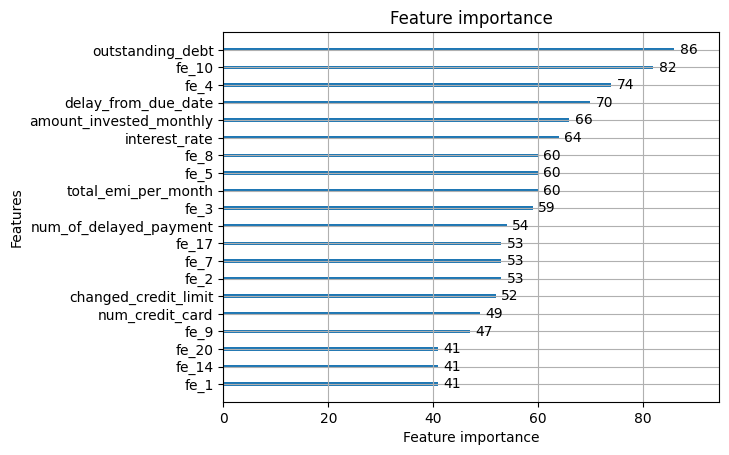

In [128]:
import matplotlib.pyplot as plt
lgb.plot_importance(model, max_num_features=20)
plt.show()